# Import, build, and analyze the complete dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df_crashes = pd.read_csv('crashes_cleaned.csv')
df_weather = pd.read_csv('weather_cleaned.csv')
df_crashes['DATE'] = pd.to_datetime(df_crashes['DATE'])
df_weather['DATE'] = pd.to_datetime(df_weather['DATE'])

In [97]:
# It looks like we're missing one day in our crash data. Let's figure out which and fix that.

In [112]:
df_crashes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5113 entries, 0 to 5112
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   DATE                 5113 non-null   datetime64[ns]
 1   NUMBER_OF_ACCIDENTS  5113 non-null   int64         
 2   TOTAL_SEVERITY       5113 non-null   float64       
 3   YEAR                 5113 non-null   int64         
 4   MONTH                5113 non-null   int64         
 5   DAY                  5113 non-null   int64         
 6   DAYOFWEEK            5113 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(5)
memory usage: 279.7 KB


In [3]:
def find_fix_dates(weather_df, crash_df):
    for row in weather_df.index:
        weather_date = weather_df.at[row, 'DATE']
        crash_date = crash_df.at[row, 'DATE']
        if str(weather_date) != str(crash_date):
            print(f"Fixing {row} - {weather_date}")
            crash_df.loc[len(crash_df.index)] = [weather_date, 0, 0, 0, 0, 0, 0]
            crash_df.sort_values(by=['DATE'], axis=0, inplace=True)
            crash_df.reset_index(drop=True, inplace=True)
            find_fix_dates(weather_df, crash_df)
        else:
            pass

    crash_df['YEAR'] = crash_df.DATE.dt.year
    crash_df['MONTH'] = crash_df.DATE.dt.month
    crash_df['DAY'] = crash_df.DATE.dt.day
    crash_df['DAYOFWEEK'] = crash_df.DATE.dt.day_of_week

In [4]:
find_fix_dates(df_weather, df_crashes)

In [8]:
# Re-export fixed files
df_crashes.to_csv('crashes_cleaned.csv', index=False)
df_weather.to_csv('weather_cleaned.csv', index=False)
df_crashes.to_csv('.../data/modified-data/crashes_cleaned.csv', index=False)
df_weather.to_csv('.../data/modified-data/weather_cleaned.csv', index=False)

OSError: Cannot save file into a non-existent directory: '..\data\modified-data'

In [10]:
# Now let's concatenate the databases
df = pd.concat([df_weather, df_crashes.drop('DATE', axis=1)], axis=1)

In [12]:
df.to_csv('full_cleaned.csv', index=False)
df.to_csv('.../data/modified-data/full_cleaned.csv', index=False)

OSError: Cannot save file into a non-existent directory: '...\data\modified-data'

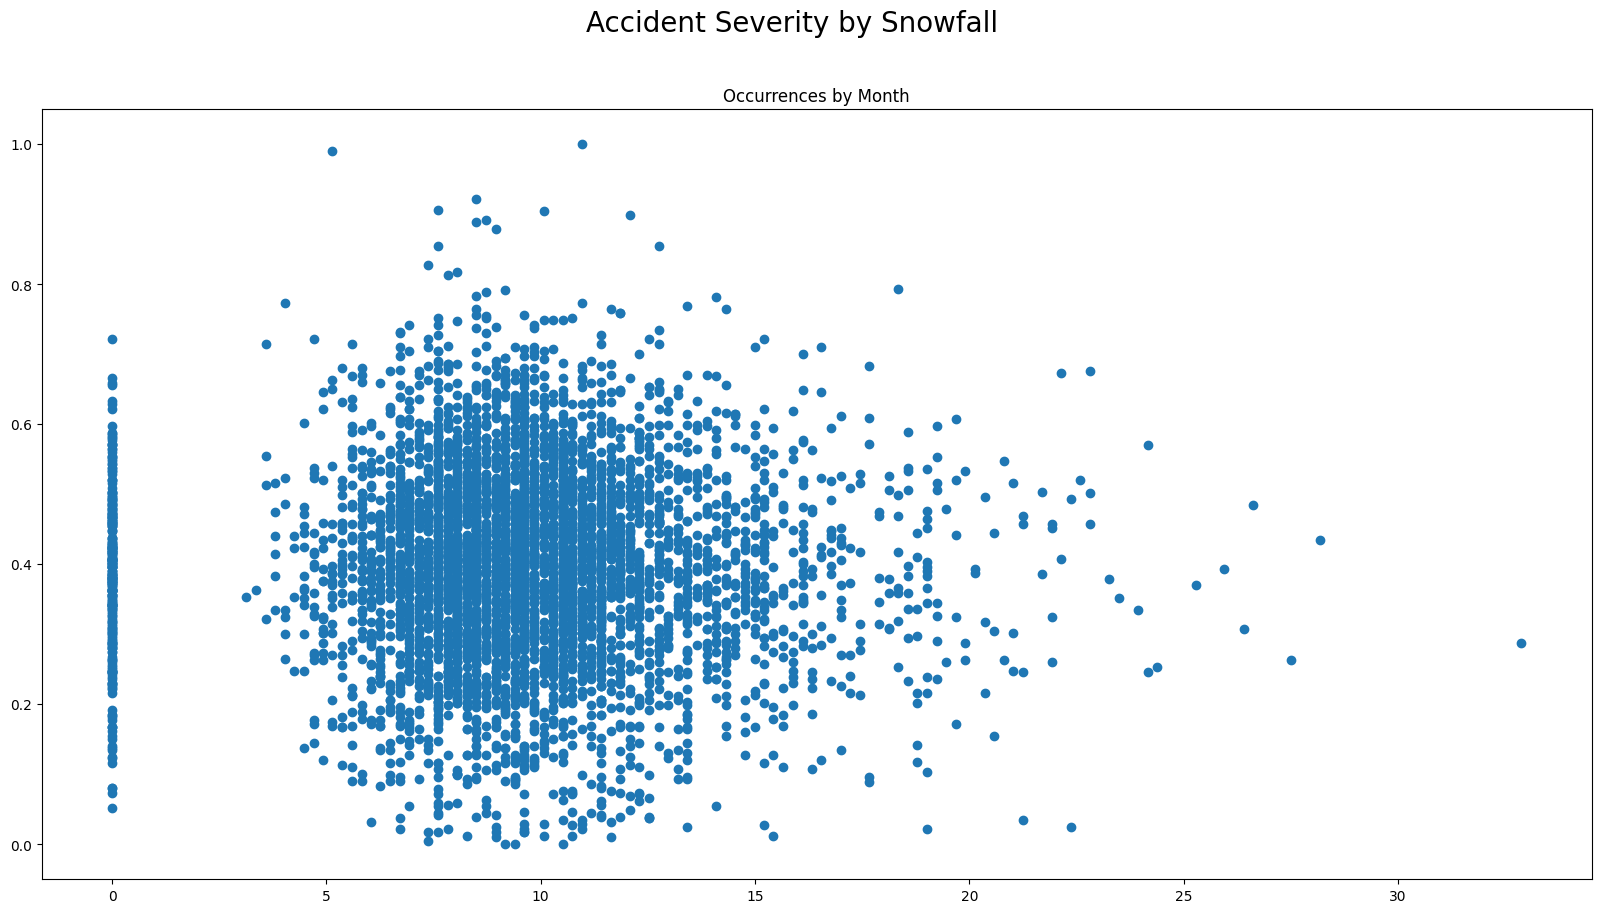

In [118]:
# Remove accidents with zero snowfall and let's look at data
#df = df.loc[df['SNOWFALL'] >= 1.0]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10), sharex='all')
fig.suptitle('Accident Severity by Snowfall', fontsize=20)
ax.scatter(x=df.AVG_WIND_SPEED, y=df.TOTAL_SEVERITY)
ax.set_title('Occurrences by Month')
# a, b = np.polyfit(df['PRECIPITATION'], df['TOTAL_SEVERITY'], deg=1)
# ax.plot(df['PRECIPITATION'], a + b * df['TOTAL_SEVERITY'])
# x_axis = np.arange(1, 13, 1)
# ax.legend()
# plt.xticks(x_axis)
plt.show()

In [119]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5114 entries, 0 to 5113
Data columns (total 35 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   DATE                  5114 non-null   datetime64[ns]
 1   AVG_WIND_SPEED        5114 non-null   float64       
 2   PRECIPITATION         5114 non-null   float64       
 3   SNOWFALL              5114 non-null   float64       
 4   SNOW_DEPTH            5114 non-null   float64       
 5   AVG_TEMP              5114 non-null   float64       
 6   TEMP_MAX              5114 non-null   float64       
 7   TEMP_MIN              5114 non-null   float64       
 8   WIND_2MIN_FASTEST     5114 non-null   float64       
 9   WIND_5MIN_FASTEST     5114 non-null   float64       
 10  WT_FOG                5114 non-null   float64       
 11  WT_HEAVY_FOG          5114 non-null   float64       
 12  WT_THUNDER            5114 non-null   float64       
 13  WT_SMALL_HAIL     

## Now we need to encode the data to numbers, split, train, and test.

### First RandomForestRegressor. Results are poor.

In [128]:
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import train_test_split, cross_val_score
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.compose import ColumnTransformer
#
# X = df.drop(['DATE', 'TOTAL_SEVERITY', 'NUMBER_OF_ACCIDENTS', 'YEAR', 'MONTH', 'DAY'], axis=1)
# y = df['NUMBER_OF_ACCIDENTS']
#
# categorical_features = ['AVG_WIND_SPEED', 'AVG_TEMP', 'TEMP_MAX', 'TEMP_MIN', 'WIND_2MIN_FASTEST', 'WIND_5MIN_FASTEST', 'WT_FOG', 'WT_HEAVY_FOG', 'WT_THUNDER', 'WT_SMALL_HAIL', 'WT_HAIL', 'WT_FROST', 'WT_BLOWING_DUST', 'WT_SMOKE_OR_HAZE', 'WT_DRIFTING_SNOW', 'WT_TORNADO', 'WT_HIGH_WINDS', 'WT_MIST', 'WT_DRIZZLE', 'WT_FREEZING_DRIZZLE', 'WT_RAIN', 'WT_FREEZING_RAIN', 'WT_SNOW', 'WT_UNK_PRECIPITATION', 'WT_FREEZING_FOG']
# one_hot = OneHotEncoder()
# transformer = ColumnTransformer(
#                 [('one_hot', one_hot, categorical_features)],
#                 remainder='passthrough')
# transformed_X = pd.get_dummies(X)
#
# X_train, X_test, y_train, y_test = train_test_split(transformed_X, y, test_size=0.2)
#
# model = RandomForestRegressor(n_estimators=100, random_state=42)
# model.fit(X_train, y_train)
# model.score(X_test, y_test)
# print(f'R2 Score: {np.mean(cross_val_score(model, X, y, cv=5, scoring="r2"))*100:.2f}%')
# Random forest regression performs very poorly. Let's move on to different models.

R2 Score: 10.84%


In [121]:
def evaluation_block_regression(model, X, y, X_test, y_test):

    """
    :param model: name of regression model
    :param X: name of X data (non-target)
    :param y: name of y data (target)
    :param X_test: name of X test data (non-target)
    :param y_test: name of y test data (target)
    """

    from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
    from sklearn.model_selection import cross_val_score
    from numpy import mean as npmean

    y_preds = model.predict(X_test)

    # Evaluation block for singular metrics (non-cross validated)
    print("Singular classifier metrics on test set:")
    print(f'R2 Score: {r2_score(y_test, y_preds)*100:.2f}%')
    print(f'MAE: {mean_absolute_error(y_test, y_preds)}')
    print(f'MSE: {mean_squared_error(y_test, y_preds)}')
    print('')

    # Evaluation block for cross val
    print("Cross validation classifier metrics on test set:")
    print(f'R2 Score: {npmean(cross_val_score(model, X, y, cv=5, scoring="r2"))*100:.2f}%')
    print(f'MAE: {npmean(cross_val_score(model, X, y, cv=5, scoring="neg_mean_absolute_error"))}')
    print(f'MSE: {npmean(cross_val_score(model, X, y, cv=5, scoring="neg_mean_squared_error"))}')
    print('')

In [122]:
# evaluation_block_regression(model, transformed_X, y, X_test, y_test)

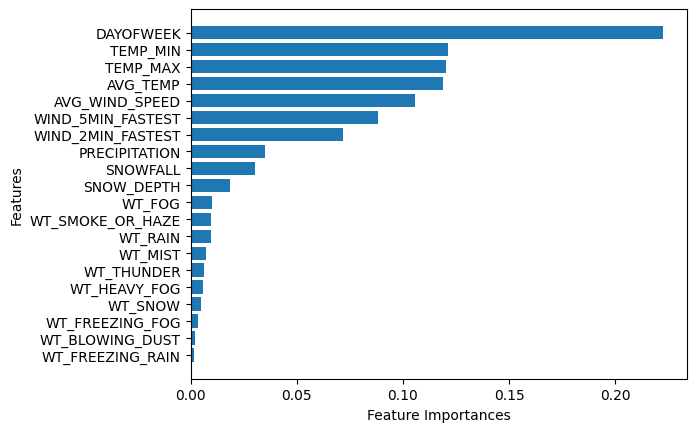

In [123]:
# def plot_features(columns, importances, n=20):
#     df = (pd.DataFrame({'features': columns,
#                         'feature_importances': importances})
#           .sort_values('feature_importances', ascending=False)
#           .reset_index(drop=True)
#           )
#
#     fix, ax = plt.subplots()
#     ax.barh(df['features'][:n], df['feature_importances'][:n])
#     ax.set_ylabel("Features")
#     ax.set_xlabel("Feature Importances")
#     ax.invert_yaxis()
#
#
# plot_features(transformed_X.columns, model.feature_importances_)

### Now for Lasso

In [133]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

X = df.drop(['DATE', 'TOTAL_SEVERITY', 'NUMBER_OF_ACCIDENTS', 'YEAR', 'MONTH', 'DAY'], axis=1)
y = df['NUMBER_OF_ACCIDENTS']

categorical_features = ['AVG_WIND_SPEED', 'AVG_TEMP', 'TEMP_MAX', 'TEMP_MIN', 'WIND_2MIN_FASTEST', 'WIND_5MIN_FASTEST', 'WT_FOG', 'WT_HEAVY_FOG', 'WT_THUNDER', 'WT_SMALL_HAIL', 'WT_HAIL', 'WT_FROST', 'WT_BLOWING_DUST', 'WT_SMOKE_OR_HAZE', 'WT_DRIFTING_SNOW', 'WT_TORNADO', 'WT_HIGH_WINDS', 'WT_MIST', 'WT_DRIZZLE', 'WT_FREEZING_DRIZZLE', 'WT_RAIN', 'WT_FREEZING_RAIN', 'WT_SNOW', 'WT_UNK_PRECIPITATION', 'WT_FREEZING_FOG']
one_hot = OneHotEncoder()
transformer = ColumnTransformer(
                [('one_hot', one_hot, categorical_features)],
                remainder='passthrough')
transformed_X = pd.get_dummies(X)

X_train, X_test, y_train, y_test = train_test_split(transformed_X, y, test_size=0.2)

model = Lasso(random_state=42)
model.fit(X_train, y_train)
model.score(X_test, y_test)
print(f'R2 Score: {np.mean(cross_val_score(model, X, y, cv=5, scoring="r2"))*100:.2f}%')

R2 Score: -3.53%


In [134]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

X = df.drop(['DATE', 'TOTAL_SEVERITY', 'NUMBER_OF_ACCIDENTS', 'YEAR', 'MONTH', 'DAY'], axis=1)
y = df['NUMBER_OF_ACCIDENTS']

categorical_features = ['AVG_WIND_SPEED', 'AVG_TEMP', 'TEMP_MAX', 'TEMP_MIN', 'WIND_2MIN_FASTEST', 'WIND_5MIN_FASTEST', 'WT_FOG', 'WT_HEAVY_FOG', 'WT_THUNDER', 'WT_SMALL_HAIL', 'WT_HAIL', 'WT_FROST', 'WT_BLOWING_DUST', 'WT_SMOKE_OR_HAZE', 'WT_DRIFTING_SNOW', 'WT_TORNADO', 'WT_HIGH_WINDS', 'WT_MIST', 'WT_DRIZZLE', 'WT_FREEZING_DRIZZLE', 'WT_RAIN', 'WT_FREEZING_RAIN', 'WT_SNOW', 'WT_UNK_PRECIPITATION', 'WT_FREEZING_FOG']
one_hot = OneHotEncoder()
transformer = ColumnTransformer(
                [('one_hot', one_hot, categorical_features)],
                remainder='passthrough')
transformed_X = pd.get_dummies(X)

X_train, X_test, y_train, y_test = train_test_split(transformed_X, y, test_size=0.2)

model = ElasticNet(random_state=42)
model.fit(X_train, y_train)
model.score(X_test, y_test)
print(f'R2 Score: {np.mean(cross_val_score(model, X, y, cv=5, scoring="r2"))*100:.2f}%')

R2 Score: -3.29%


In [ ]:
# So we're getting some pretty poor results. I'm going to wrap up this notebook in the dev-one directory and move on to dev-two where I'll further refine the data and maybe try turning this into a classification problem rather than a regression one.